# project machine_learning

#### Talya Cuperman 213288343
#### Ester Carmiel 324125079

## Github link-

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
import seaborn as sns
from sklearn.pipeline import Pipeline
import requests
import time
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
import ppscore as pps

### step 1- Data preparation


### הסברים ומהלכים שעשינו על הדאטה
- השלמנו ידנית ערכים חסרים במספר עמודות לפי הכתוב בתאור
- מחקנו את העמודות של התיאור,ימי כניסה,מס תשלומים כי הם לא רלוונטים לנו למודל
 - הורדנו שורות עם ערכים חסרים עבור הטריין בלבד בעמודות שכונה,כתובת, קומה ומחיר
 -  השלמנו לאפס את הערכים החסרים בעמודות גינה,נגישות ומס תמונות
 - טיפלנו בערכים בעמודת סוג הדירה, הורדנו את המילים הלא רלוונטית כמו 'להשכרה' וכו
 - הוצאנו מהטריין שורות של נכסים לא רלוונטים למודל כמו מחסן,חנייה וכללי, אם זה קורה בטסט- שישנה את זה לדירה
 -  ערכים בעייתים בעמודת הקומה כמו '3 מתוך 5'או קרקע מתוך קרקע סידרנו שיהיה רק מספר בקומה/ סך קומות בהתאם לנדרש. 
- היו שורות שמספר החדרים בהם היה אפס לכן טיפלנו בהם בצורה הבאה: לקחנו את שטח הדירה וחישבנו חציון בהתאמה לשאר השטחים ולפי מס החדרים בהתאמה,במידה ולא היה שטח מתאים לקחנו שניים למעלה ושניים למטה
-  עבור הטריין בלבד הגדרנו טווח של מחירים ושטח דירה לא הגיוניים והורדנו את העמודות האלו
- אם בשורה מסוימת סך הקומות בבניין היה גדול מהקומה הנוכחית החלפנו בינהם
- ראינו שיש בדאטה שורות כפולות אבל עם מרחקים שונים אז איחדנו את השורות הכפולות ובמרחק כתבנו אפס,לאחר מכן במקומות שהערך של המרחק היה חסר,אפס או ערך קיצוני מצאנו מחדש את המרחק בעזרת הפונקציה שבנינו בחלק אחד של הפרוייקט
- במקומות של ערכים חסרים בארנונה מילאנו לפי ממוצע ערכים למטר
- בערכים חסרים של מיסי בניין נצטרך להסתכל על הממוצע בשוק.כדי לחשב את הממוצע בשוק עשינו ממוצע לפרמטרים הבאים: שטח דירה,כמות חדרים ושכונה- בעצם הערכים המשפיעים על מיסי הבניין. במידה ולא ימצא ממוצע כלל נתאים את הערך החסר לפי השכונה והשטח בלבד,אם גם כעת לא ימצא ממוצע נחשב עפ מס חדרים ושטח בלבד
- כעת נתייחס לעמודת הכתובת, לאחר מחשבה הבנו שעמודת הכתובת לא רלוונטית לכשעצמה, מה שרלוונטי למחיר זה המרחק של הכתובת מהמרכז ובעצם אם אין כתובת המרחק יהיה שגוי ועלול לגרום לטעות בניבוי ולכן מחקנו את השורות עם הערכים החסרים בטריין בלבד.
- הוספנו עמודת יוקרה שבודקת את רמת היוקרתיות של הדירה עפ השילוב בין הקומה,סך הקומות בבניין ואם יש מעלית או אין.כך כל דירה קיבלה ציון עפ פיצר שבנינו שמחשב את הפרמטרים בהתאם. תוך התיחסות אם מדובר בבניין ללא מעלית וקומה גבוה/ בניין עם מעלית בקומה גבוה וכן לגבי דירות נמוכות יותר בבנינים אלו.
- הוספנו עמודה שמחשבת את ממוצע גודל החדר בדירה
- נבצע עיבוד מקדים לנתונים,בעת אימון הוא מתאים סטנדרניזציה לעמודות נומריות ווואן הוט לקטגוריליות ושומר אותם במילון,בעת הבדיקה הוא משתמש במעבדים שנשמרו כדי להחיל את אותם שינויים על הנתונים החדשים
 - בנוסף,כדי להשלים ערכים חסרים בעמודת סך הקומות בבניין בדקנו האם ישנן כתובות זהות ועל פיהן השלמנו את סך הקומות בבניין,לאחר בדיקה ראינו שאין כאלה ולכן אף כתובת לא תוכל לעזור לנו ולכן לא הכנסו לפונקציה 


In [2]:
preprocessor = None
numeric_medians = {}
default_values = {}
avg_arnona_per_meter = None
building_tax_medians = {}
room_reference_data = None

def prepare_data(data, mode='train'):
    if mode not in ['train', 'test']:
        raise ValueError("mode must be either 'train' or 'test'")

    global numeric_medians, default_values
    global avg_arnona_per_meter, building_tax_medians, room_reference_data
    
    data = data.copy()
    if mode == 'train':
        data = data.dropna(subset=['price'])
        data = data[data['neighborhood'].notnull()]
        data = data[data['floor'].notnull()]
        data = data[data['address'].notnull()]
    data = data.drop('description', axis=1)
    data = data.drop('days_to_enter', axis=1)
    data = data.drop('num_of_payments', axis=1)


    if mode == 'train':
        numeric_floor = pd.to_numeric(data['floor'], errors='coerce')

        numeric_medians['floor'] = numeric_floor.median()

        default_values = {
            'property_type': 'דירה',
            'neighborhood': data['neighborhood'].mode()[0],
            'address': data['address'].mode()[0] 
        }

    else:
        data['floor'] = data['floor'].where(data['floor'].notna(), numeric_medians['floor'])

        for col, default_val in default_values.items():
            if col in df.columns:
                data[col] = data[col].fillna(default_val)

    

    data[['garden_area', 'handicap','num_of_images']] = data[['garden_area', 'handicap','num_of_images']].fillna(0)

    data.loc[data['property_type'].isin(["פרטי/קוטג'"]), 'building_tax'] = 0

    
   # ניקוי סוג הנכס
    data['property_type'] = (
        data['property_type']
        .str.replace('/ ', '/', regex=False)
        .str.replace(' להשכרה', '', regex=False)
        .str.replace('להשכרה', '', regex=False)
        .str.strip()
    )

    
    if mode == 'train':
        data = data[~data['property_type'].isin(['כללי', 'מחסן', 'חניה'])]
    elif mode == 'test':
        data['property_type'] = data['property_type'].replace(['כללי', 'מחסן', 'חניה'], 'דירה')


    unique_values_property_type = data['property_type'].unique().tolist()

    def extract_real_floor(row):
        floor_str = str(row['floor']).strip()
        total_str = str(row['total_floors']).strip()

        if 'מתוך' in floor_str:
            if 'קרקע' in floor_str:
                return 0
            else:
                return pd.to_numeric(floor_str.split(' מתוך ')[0], errors='coerce')
        elif floor_str == 'קרקע':
            return 0
        if floor_str.isdigit() and total_str.isdigit():
            if len(floor_str) > len(total_str) and floor_str.endswith(total_str):
                floor_val = floor_str[:-len(total_str)]
                return pd.to_numeric(floor_val, errors='coerce')
        if floor_str == total_str:
            return pd.to_numeric(floor_str, errors='coerce')
        elif floor_str.endswith(total_str) and len(floor_str) > len(total_str):
            floor_val = floor_str[:-len(total_str)]
            return pd.to_numeric(floor_val, errors='coerce')
        else:
            return pd.to_numeric(floor_str, errors='coerce')

    processed_floor = data.apply(extract_real_floor, axis=1)
    data['floor'] = processed_floor
    data['floor'] = data['floor'].astype(float)
    data['total_floors'] = data['total_floors'].fillna(data['floor'])

    def extract_real_floor(row):
        floor_str = str(row['floor']).strip()
        total_str = str(row['total_floors']).strip()

        if 'מתוך' in floor_str:
            if 'קרקע' in floor_str:
                return 0
            else:
                return pd.to_numeric(floor_str.split(' מתוך ')[0], errors='coerce')
        elif floor_str == 'קרקע':
            return 0
        if floor_str.isdigit() and total_str.isdigit():
            if len(floor_str) > len(total_str) and floor_str.endswith(total_str):
                floor_val = floor_str[:-len(total_str)]
                return pd.to_numeric(floor_val, errors='coerce')
        if floor_str == total_str:
            return pd.to_numeric(floor_str, errors='coerce')
        elif floor_str.endswith(total_str) and len(floor_str) > len(total_str):
            floor_val = floor_str[:-len(total_str)]
            return pd.to_numeric(floor_val, errors='coerce')
        else:
            return pd.to_numeric(floor_str, errors='coerce')

    processed_floor = data.apply(extract_real_floor, axis=1)
    data['floor'] = processed_floor
    data['floor'] = data['floor'].astype(float)
    data['total_floors'] = data['total_floors'].fillna(data['floor'])


    def impute_rooms_by_area(row):
        if row['room_num'] == 0:
            area = row['area']
            similar = room_reference_data[
                (room_reference_data['area'] >= area - 5) &
                (room_reference_data['area'] <= area + 5) &
                (room_reference_data['room_num'] > 0)
            ]
            if not similar.empty:
                return round(similar['room_num'].median())
            fallback = room_reference_data[
                (room_reference_data['area'] >= area - 2) &
                (room_reference_data['area'] < area) &
                (room_reference_data['room_num'] > 0)
            ]
            if not fallback.empty:
                return round(fallback['room_num'].median())
        return row['room_num']

    if mode == 'train':
        room_reference_data = data.copy()

    data['room_num'] = data.apply(impute_rooms_by_area, axis=1)


    if mode == 'train':
        data = data[data['price'] <= 30000]
        data = data[data['price'] >= 2001]
        data = data[data['area'] >= 20]

    def fix_floor_values(row):
        if pd.notna(row['floor']) and pd.notna(row['total_floors']):
            if row['floor'] > row['total_floors']:
                return pd.Series({'floor': row['total_floors'], 'total_floors': row['floor']})
        return pd.Series({'floor': row['floor'], 'total_floors': row['total_floors']})

    data[['floor', 'total_floors']] = data.apply(fix_floor_values, axis=1)
    
    def merge_duplicates_and_zero_distance(df, distance_col='distance_from_center'):
   
        cols_to_check = [col for col in df.columns if col != distance_col]

        duplicate_mask = df.duplicated(subset=cols_to_check, keep=False)

        df_duplicates = (
            df[duplicate_mask]
            .drop_duplicates(subset=cols_to_check)
            .assign(**{distance_col: 0})
        )

        df_unique = df[~duplicate_mask]

        df_cleaned = pd.concat([df_unique, df_duplicates], ignore_index=True)
    
        return df_cleaned
    data = merge_duplicates_and_zero_distance(data)

    api_key =  # הכנסי כאן את המפתח שלך  

    def get_distance(location):
        full_address = location + ", תל אביב"
        url = "https://routes.googleapis.com/directions/v2:computeRoutes"
        headers = {
            'Content-Type': 'application/json',
            'X-Goog-Api-Key': api_key,
            'X-Goog-FieldMask': 'routes.distanceMeters'
        }
        body = {
            "origin": {"address": full_address},
            "destination": {"address": "Dizengoff Square, Tel Aviv"},
            "travelMode": "DRIVE",
            "routingPreference": "TRAFFIC_AWARE"
        }

        response = requests.post(url, headers=headers, json=body)
        try:
            if response.status_code == 200:
                data = response.json()
                if 'routes' in data and len(data['routes']) > 0:
                    return data['routes'][0]['distanceMeters']
                else:
                    return None
            else:
                return None
        except Exception as e:
            return None

    def update_missing_or_invalid_distances(df, address_col='address', distance_col='distance_from_center'):
        mask = df[distance_col].isna() | (df[distance_col] == 0) | (df[distance_col] > 11500)
    

        for idx in df[mask].index:
            address = df.loc[idx, address_col]
            dist = get_distance(address)
            if dist is not None:
                df.at[idx, distance_col] = dist
                
            time.sleep(1) 
        return df

    data = update_missing_or_invalid_distances(data, address_col='address', distance_col='distance_from_center')


    if 'address' in data.columns:
        data.drop(columns=['address'], inplace=True)
        
    if mode == 'train':
        valid_rows = data[(data['monthly_arnona'].notna()) & (data['monthly_arnona'] > 0) & (data['area'].notna())]
        valid_rows = valid_rows.copy()
        valid_rows['arnona_per_meter'] = valid_rows['monthly_arnona'] / valid_rows['area']
        avg_arnona_per_meter = valid_rows['arnona_per_meter'].mean()

    data.loc[(data['monthly_arnona'].isna()) | (data['monthly_arnona'] == 0), 'monthly_arnona'] = \
        data['area'] * avg_arnona_per_meter

    

    def fill_building_tax(df):
        df['area_range'] = (df['area'] // 10) * 10

        if mode == 'train':
            building_tax_medians.clear()
            levels = [
                ('level1', ['neighborhood', 'room_num', 'area_range']),
                ('level2', ['neighborhood']),
                ('level3', ['room_num', 'area_range']),
            ]
            for name, groupby_cols in levels:
                medians = df.groupby(groupby_cols)['building_tax'].median()
                building_tax_medians[name] = (groupby_cols, medians)

        for name, (cols, medians) in building_tax_medians.items():
            idx = df['building_tax'].isnull()
            try:
                df.loc[idx, 'building_tax'] = df[idx].set_index(cols).index.map(medians)
            except:
                continue

        df.drop(columns=['area_range'], inplace=True, errors='ignore')
        return df

    data = fill_building_tax(data)

    if mode == 'test':
        if 'building_tax' not in data.columns:
            data['building_tax'] = 0

    def calculate_luxury_score(row):
        floor = row['floor']
        total_floors = row['total_floors']
        has_elevator = row['elevator']
        property_type = row['property_type']

        if property_type in ['פרטי/קוטג׳', 'דו משפחתי']:
            return 1.0
        if total_floors == 0:
            return 1.0

        floor = int(floor)
        total_floors = int(total_floors)

        if has_elevator == 1:
            if floor == 0:
                return 0.95
            elif total_floors == 1:
                return 1.0
            else:
                norm_floor = (floor - 1) / (total_floors - 1)
                bonus = 0.05 * np.log1p(total_floors)
                return round(min(1.0 + norm_floor * bonus, 1.1), 3)
        else:
            if floor == 0:
                penalty = 0.25 * (total_floors / 10)
                return round(max(0.6, 1.0 - penalty), 3)
            else:
                norm_floor = floor / total_floors
                penalty = 0.5 * norm_floor + 0.1 * (total_floors / 10)
                return round(max(0, 1.0 - penalty), 3)

    data['luxury_score'] = data.apply(calculate_luxury_score, axis=1)
    data['avg_room_size'] = data['area'] / data['room_num']
    
    data = data.drop('area', axis=1)

    if mode == 'train':
        data = data[data['building_tax'].notnull()]

    data.reset_index(drop=True, inplace=True)


    if mode == 'train':
        numeric_medians = data.select_dtypes(include='number').median()

        default_values = {
            'property_type': 'דירה',
            'neighborhood': data['neighborhood'].mode()[0]
        }

    else:
        for col in data.select_dtypes(include='number').columns:
            if col in numeric_medians:
                data[col] = data[col].fillna(numeric_medians[col])

        for col, default_val in default_values.items():
            if col in df.columns:
                data[col] = data[col].fillna(default_val)

    
    global preprocessor

    if preprocessor is None:
        preprocessor = {}

# בנייה של עמודות נומריות וקטגוריאליות
    if mode == "train":
        numeric_features_to_scale = [col for col in data.select_dtypes(include=np.number).columns if col != 'price']
        categorical_features_to_encode = data.select_dtypes(include='object').columns.tolist()

        scaler = StandardScaler()
        data[numeric_features_to_scale] = scaler.fit_transform(data[numeric_features_to_scale])
        preprocessor['scaler'] = scaler
        preprocessor['numeric_cols'] = numeric_features_to_scale

        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_array = encoder.fit_transform(data[categorical_features_to_encode])
        encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features_to_encode), index=data.index)

        data = data.drop(columns=categorical_features_to_encode)
        data = pd.concat([data, encoded_df], axis=1)
        preprocessor['encoder'] = encoder
        preprocessor['categorical_cols'] = categorical_features_to_encode

    elif mode == "test":
        if not preprocessor:
            raise RuntimeError("Preprocessor has not been fitted yet. Please run with mode='train' first.")

    # השלמה של עמודות חסרות בנתונים
        for col in preprocessor['numeric_cols']:
            if col not in data.columns:
                data[col] = 0  # או אפשרות אחרת: np.nan
    
    # הקפדה על סדר ועמודות זהות
        data_numeric = data[preprocessor['numeric_cols']]
        data[preprocessor['numeric_cols']] = preprocessor['scaler'].transform(data_numeric)

        encoder = preprocessor['encoder']
        for col in preprocessor['categorical_cols']:
            if col not in data.columns:
                data[col] = ''  # או ערך ברירת מחדל מתאים

        encoded_array = encoder.transform(data[preprocessor['categorical_cols']])
        encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(preprocessor['categorical_cols']), index=data.index)

        data = data.drop(columns=preprocessor['categorical_cols'])
        data = pd.concat([data, encoded_df], axis=1)

    df_prepared = data


    return data
    
        

פיצ'ר נוסף שלא הכנסנו לפונקציה

In [3]:
def fill_missing_total_floors_by_address(data):
   
    rows_with_missing = data[data['total_floors'].isnull()]

    for index, row in rows_with_missing.iterrows():
        current_address = row['address']
        matching_rows = data[
            (data['address'] == current_address) & (data['total_floors'].notnull())
        ]
        if not matching_rows.empty:
            filled_value = matching_rows.iloc[0]['total_floors']
            data.loc[index, 'total_floors'] = filled_value

    return data


In [4]:
data = pd.read_csv("train.csv")
prepared = prepare_data(data,'train')

## coralation with pps

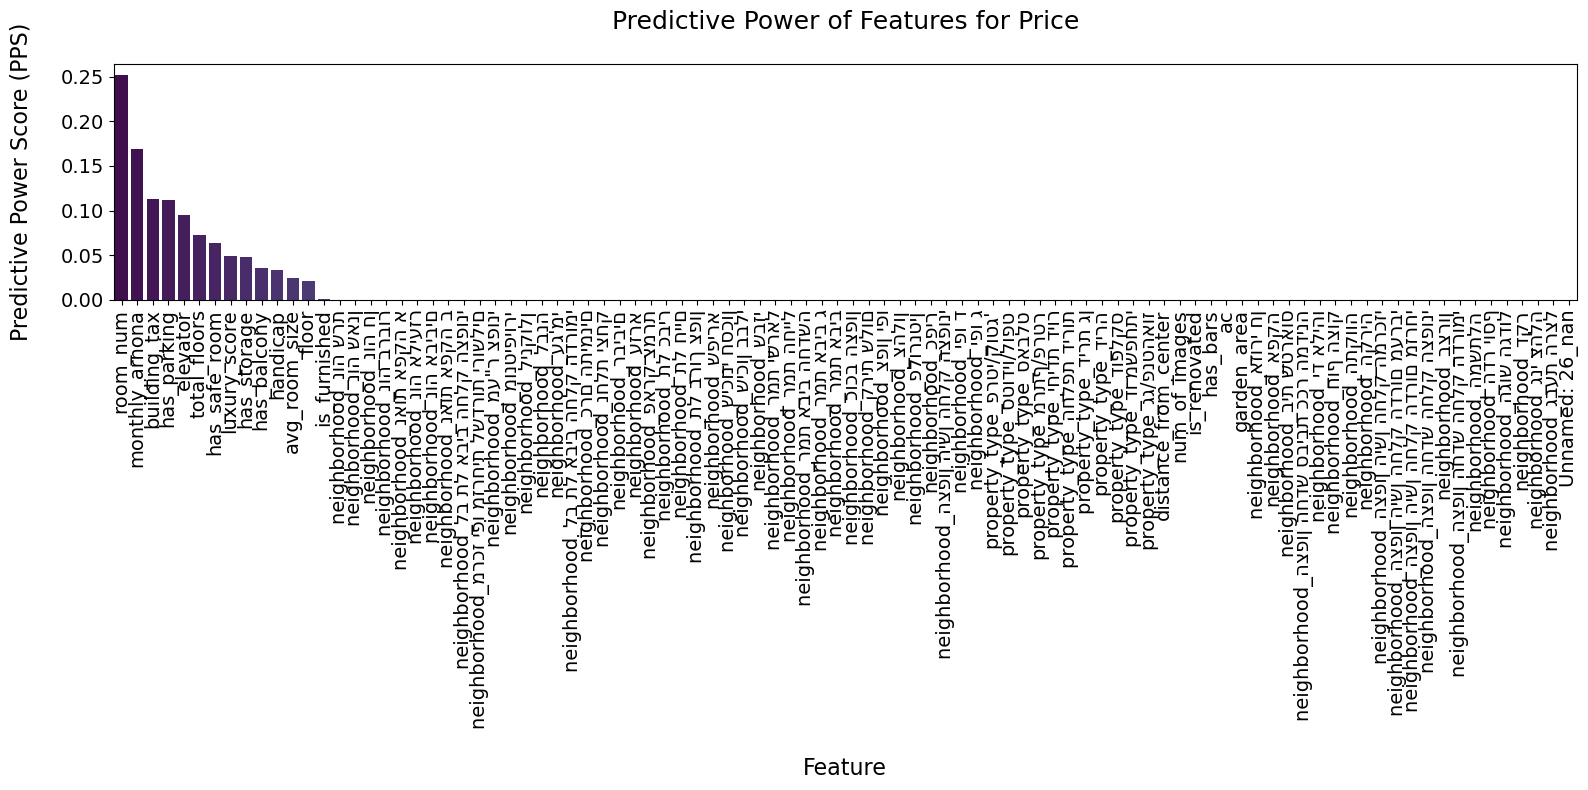

In [5]:
pps_results = pps.predictors(prepared, "price")

pps_results_sorted = pps_results.sort_values(by='ppscore', ascending=False)

plt.figure(figsize=(16,8))
sns.barplot(x='x', y='ppscore', data=pps_results_sorted, palette='viridis')

plt.xticks(rotation=90, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Feature', fontsize=16, labelpad=20)
plt.ylabel('Predictive Power Score (PPS)', fontsize=16, labelpad=20)
plt.title('Predictive Power of Features for Price', fontsize=18, pad=25)

plt.tight_layout()
plt.show()

pps הקוד מבצע ניתוח של מדד

מדד שמודד את כוח הניבוי של כל פיצ'ר בנפרד ביחס למטרה  בצורה יותר גמישה מקורלציה רגילה

אנחנו רואים שיש כ15 עמודות משפיעות על המודל אך לאחר בדיקה ראינו שגם שאר העמודות משםיעות אך בצורה נמוכה משמעותית ולכן בכל זאת בחרנו להשאיר אותם במודל

## step 2 -Elestic Net 

 ###  pps העמודות שישפיעו לדעתנו על המודל לפי בדיקת 
- room_num
- floor
- area
- total_floors
- has_ parking 
- elavator
- has_safe_room
- has_balacony
- is_furnished
- handicap
- has_storage
- mounthly_arnona
- luxury_score
- avg_room_size
- building_tax

<div dir="rtl">

ביצענו ניתוח קורלציה בין הפיצ'רים וזיהינו שיש קורלציה גבוהה של `area` עם פיצ'רים נוספים.  
זה מעיד על חפיפה במידע שעלולה לפגוע במודל ולהישען על מידע מיותר.  
השווינו בין המודלים וראינו שגם ללא העמודה המודל אף משתפר.  
לכן, כדי להפחית את התלות , בחרנו להסיר עמודה זו.

כמו כן,ראינו שיש קורלציה גבוהה בין מעלית לחנייה אך מכיוון שאין באמת קשר בין הדברים ולאחר בדיקה גם מוריד את דיוק המודל החלטנו לא לטפל בקורלציה הזו
</div>


תוצאות המודל Elastic Net:
R²: 0.665 | RMSE: 2292.143 | MAE: 1469.475


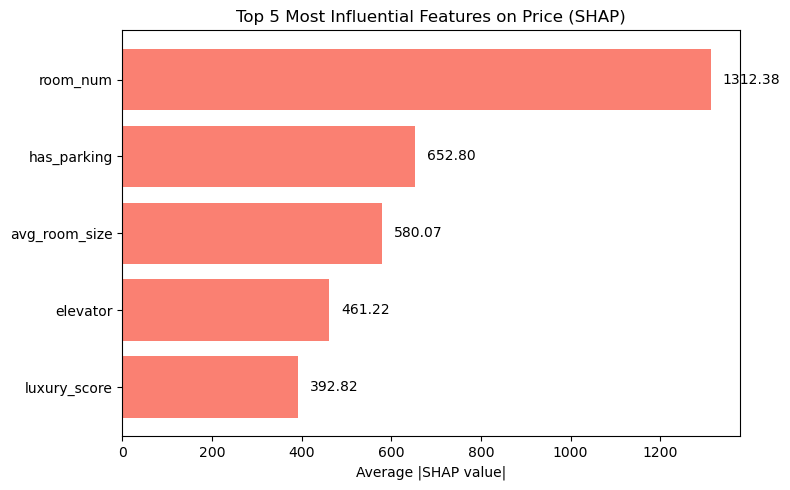

In [6]:
y = prepared['price']
X_prepared = prepared.drop(columns=['price'])  # הסרת עמודת מטרה ו-area

# שלב 2: אימון מודל ElasticNetCV
alphas = [0.01]
l1_ratios = [0.99]
en_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=10, max_iter=5000, random_state=42)
en_model.fit(X_prepared, y)

# שלב 3: הערכת המודל
y_pred = en_model.predict(X_prepared)
elastic_r2 = r2_score(y, y_pred)
elastic_rmse = np.sqrt(mean_squared_error(y, y_pred))
elastic_mae = mean_absolute_error(y, y_pred)
print("תוצאות המודל Elastic Net:")
print(f"R²: {elastic_r2:.3f} | RMSE: {elastic_rmse:.3f} | MAE: {elastic_mae:.3f}")

# שלב 4: חישוב חשיבות פיצ'רים עם SHAP
explainer = shap.Explainer(en_model, X_prepared)
shap_values = explainer(X_prepared)

mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.Series(mean_abs_shap, index=X_prepared.columns)

# בחירת 5 הפיצ'רים המשפיעים ביותר
top5 = feature_importance.sort_values(ascending=False).head(5)


# שלב 5: ציור גרף
plt.figure(figsize=(8, 5))
bars = plt.barh(top5.index[::-1], top5.values[::-1], color='salmon')  # מהגבוה לנמוך
plt.xlabel("Average |SHAP value|")
plt.title("Top 5 Most Influential Features on Price (SHAP)")

# הוספת ערכים על הגרף
for bar in bars:
    width = bar.get_width()
    plt.text(width + top5.max() * 0.02, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center')

plt.tight_layout()
plt.show()


## חמשת המאפיינים בעלי ההשפעה הגדולה ביותר:
* room_num
* has_parking
* avg_room_size
* elevator
* luxury_score

## step 3- Decision Tree


 #####   מאותה סיבה כמו במודל הקודם הורדנו את עמודת area.
 


📌 הפרמטרים הטובים ביותר:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

 תוצאות המודל Random Forest:
R²: 0.874 | RMSE: 1407.427 | MAE: 896.016

 10-fold CV RMSE: 2614.7538 (+/- 439.6666)


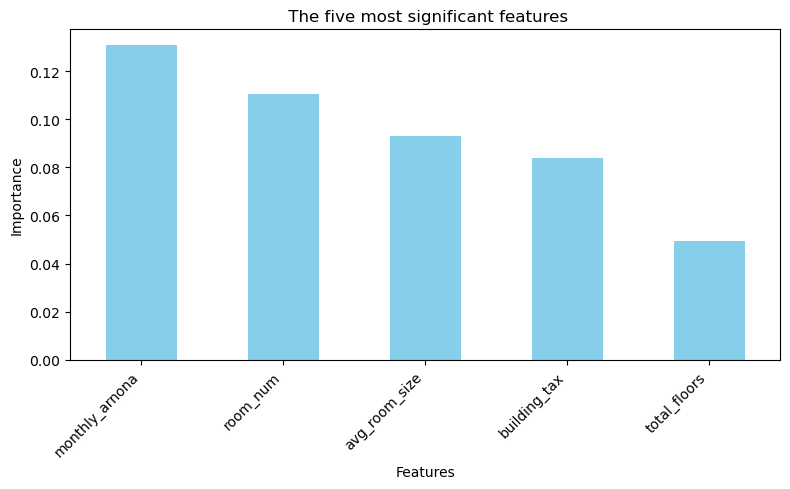

In [7]:
df = prepared.copy()
target = 'price'
X = df.drop(columns=[target])
y = df[target]

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

search = GridSearchCV(rf, param_grid, cv=10, scoring='neg_root_mean_squared_error', n_jobs=-1)
search.fit(X, y)

print(f"📌 הפרמטרים הטובים ביותר:\n{search.best_params_}\n")

best_rf = search.best_estimator_
y_pred_rf = best_rf.predict(X)

rf_r2 = r2_score(y, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y, y_pred_rf))
rf_mae = mean_absolute_error(y, y_pred_rf)

print(" תוצאות המודל Random Forest:")
print(f"R²: {rf_r2:.3f} | RMSE: {rf_rmse:.3f} | MAE: {rf_mae:.3f}\n")

cv_scores = cross_val_score(best_rf, X, y, cv=10, scoring='neg_root_mean_squared_error')
print(f" 10-fold CV RMSE: {-np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
top5_features = feature_importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(8, 5))
top5_features.plot(kind='bar', color='skyblue')
plt.title(' The five most significant features')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## grid search

<div dir="rtl">
לביצוע אופטימיזציה של הפרמטרים במודל Random Forest השתמשנו בשיטת Grid Search עם 10-fold Cross Validation.
בחרתי ב־Grid Search מהסיבות הבאות:
מרחב הפרמטרים שלי היה מצומצם יחסית, ולכן אפשר לבצע חיפוש מלא מבלי שהזמן יהיה ארוך מדי.
Grid Search מאפשרת חיפוש שיטתי של כל הצירופים, ומוודאת שלא מפספסים שילוב מוצלח.
השיטה פשוטה, שקופה, וקלה להצגה.
</div>

### חמשת המאפיינים בעלי ההשפעה הגדולה ביותר:
* mounthly_arnona
* room_num
* avg_room_size
* building_tax
* total_floor

### השוואה בין המודלים

In [8]:
results = {
    'מודל': ['Elastic Net', 'Random Forest'],
    'RMSE': [elastic_rmse, rf_rmse], 
    'MAE': [elastic_mae, rf_mae],
    'R²': [elastic_r2, rf_r2]
}

performance_df = pd.DataFrame(results)
performance_df.set_index('מודל', inplace=True)

print(" השוואת ביצועי המודלים:")
display(performance_df)

# top5 מהשפעות SHAP של ElasticNet
elastic_top5 = top5.index.tolist()

# top5 לפי חשיבות מהיער המקרי
rf_top5 = top5_features.index.tolist()

# יצירת טבלת השוואה
features_df = pd.DataFrame({
    'Elastic Net': elastic_top5,
    'Random Forest': rf_top5
})

print(" השוואת חמשת הפיצ’רים החשובים ביותר בכל מודל:")
display(features_df)


 השוואת ביצועי המודלים:


,RMSE,MAE,R²
מודל,,,
Elastic Net,2292.142596,1469.475390,0.665291
Random Forest,1407.426500,896.015716,0.873807


 השוואת חמשת הפיצ’רים החשובים ביותר בכל מודל:


,Elastic Net,Random Forest
0,room_num,monthly_arnona
1,has_parking,room_num
2,avg_room_size,avg_room_size
3,elevator,building_tax
4,luxury_score,total_floors


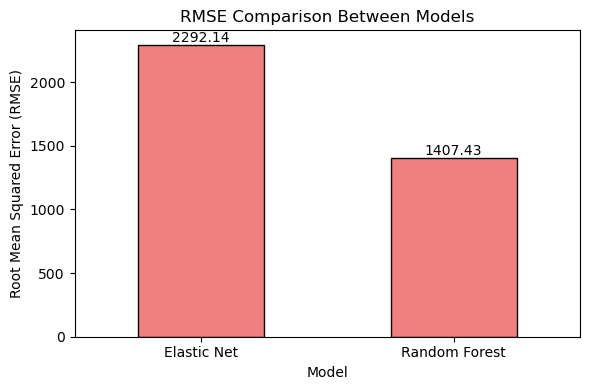

In [9]:
plt.figure(figsize=(6, 4))
performance_df['RMSE'].plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("RMSE Comparison Between Models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Model")
plt.xticks(rotation=0)

# Display values above bars
for idx, val in enumerate(performance_df['RMSE']):
    plt.text(idx, val + 0.01 * max(performance_df['RMSE']), f"{val:.2f}", ha='center')

plt.tight_layout()
plt.show()


<div dir="rtl">
 מבחינת המדדים:
</div>
<div dir="rtl">
המודל הלא-לינארי  הציג ביצועים טובים בהרבה ממודל האלסטיק נט בכל המדדים . הדבר מצביע על כך שהקשרים בין הפיצ’רים למחיר אינם לגמרי לינאריים, ולכן מודל פשוט כמו אלסטיק נט לא הצליח ללכוד את המורכבות של הקשרים כמו שהצליח מודל העץ.
יתכן גם שהיו אינטראקציות מורכבות בין משתנים (כמו בין מספר חדרים לארנונה), שמודל העץ ידע ללמוד – בעוד שמודל לינארי מתקשה לעשות זאת.
 </div>
 
  <div dir="rtl">
 מבחינת הפיצ’רים:
 </div>
    <div dir="rtl">
שני המודלים זיהו את הפיצ'רים מספר חדרים וממוצע גודל חדר כחשובים במיוחד, מה שמצביע על הקשר הישיר והברור שלהם למחיר הדירה – כלומר, יותר חדרים או חדרים גדולים יותר משפיעים על המחיר באופן מובהק.
מודל האלסטיק נט התמקד בפיצ’רים עם השפעה ברורה ולינארית – כמו חנייה, מעלית ורמת יוקרה. לעומתו, מודל העץ הדגיש פיצ’רים שאולי מעידים על קשרים מורכבים או עקיפים – כמו גובה הארנונה החודשית או מספר הקומות בבניין, שיכולים לשקף מיקום, יוקרה או תשתיות, בצורה עקיפה.
לכן ניתן להסיק שמודל העץ לא רק מתאים יותר לנתונים שלנו, אלא גם מצליח לחשוף דפוסים עמוקים יותר שלא באים לידי ביטוי בצורה לינארית.

</div>